In [1]:
import pandas as pd
import json

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import math

In [79]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
  'font.size': 8,
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'pgf.texsystem': "pdflatex",
  'pgf.preamble': r'\usepackage{amsfonts}',
  #"font.family": "serif",
  #"pgf.rcfonts": False,
})

In [40]:
fig_width=6
fig_height=1.5

func_key = "function_name"
dataset_key = "dataset"
dataset_size_key = "dataset_elem_count"
probing_dist_key = "probing_dist"
throughput_key = "throughput" 
order_key = "order"
presorted_key = "presorted"

In [41]:
color_i = 0
colors = {}
def get_color(fun):
    global color_i
    global colors
    
    key = fun.lower()
    if key not in colors:
        options = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS)[0:-1]
        colors[key] = options[color_i % len(options)]
        color_i += 1
    return colors[key]

def reset_colors():
    global color_i
    global colors
    color_i = 0
    colors = {}

In [21]:
def dataset_name(d):
    return {'amzn': "amazon", 
            'fb': "facebook", 
            'gap_10': "gapped 10%",
            'osm': "open street map",
            'seq': "sequential",
            'normal': "normal",
            'uniform': "uniform",
            'wiki': "wikipedia"}[d]

def function_name(f, params=False):
    return {'BBHash1' : 'BBHash ($\lambda=1$)' if params else 'BBHash',
             'BBHash2': 'BBHash ($\lambda=2$)' if params else 'BBHash',
             'BitMWHC': 'BitMWHC',
             'CompactTrie': 'Compacted Trie',
             'CompactedCompactTrie': 'Static Compacted Trie',
             'CompactedMWHC': "Compacted MWHC",
             'CompressedMWHC': "Compressed MWHC",
             'CompressedRankHash': "Compressed RankHash",
             'DoNothingHash': "DoNothing",
             'FST': "Fast Succinct Trie",
             'HollowTrie': "Hollow Trie",
             'MWHC': "MWHC",
             'MapOMPHF': "MapOMPHF",
             'RankHash': "RankHash",
             'RecSplit_leaf12_bucket9': "RecSplit (l=12, b=9)" if params else "RecSplit",
             'SimpleHollowTrie': "Simple HollowTrie"}[f]

def throughput_order(x):
    return {
        'DoNothingHash': 0,
        'RankHash': 1,
        'CompressedRankHash': 2,
        'MapOMPHF': 3,
        'RecSplit_leaf12_bucket9': 4,
        'BBHash1': 5,
        'BBHash2': 6,
        'CompactTrie': 7,
        'CompactedCompactTrie': 8,
        'SimpleHollowTrie': 9,
        'HollowTrie': 10,
        'FST': 11,
        'MWHC': 12,
        'CompressedMWHC': 13,
        'CompactedMWHC': 14,
        'BitMWHC': 15,
    }[x]

def round_to_nearest_pow_10(num):
    next_smallest = 10**math.floor(math.log10(num))
    return next_smallest * math.ceil(float(num) / float(next_smallest))

In [22]:
results_file = f"../results.json"
with open (results_file) as file:
    data = json.load(file)
    df = pd.json_normalize(data, "benchmarks")

In [58]:
th_df = df[(df["name"].str.startswith("LookupTime"))].copy(deep=True)
th_df[func_key] = th_df["label"].apply(lambda x : x.split(":")[0])
th_df[dataset_key] = th_df["label"].apply(lambda x : dataset_name(x.split(":")[1]))
th_df[dataset_size_key] = th_df[dataset_size_key].apply(round_to_nearest_pow_10)
th_df = th_df[th_df[dataset_size_key] >= 10000]
th_df[probing_dist_key] = th_df["label"].apply(lambda x : x.split(":")[2])
th_df[order_key] = th_df[func_key].apply(throughput_order)
empty_th_loop_overheads = th_df[th_df[func_key].str.startswith("DoNothingHash")].groupby([dataset_size_key]).agg({dataset_size_key: 'min', "cpu_time": 'mean'})
def overhead(size):
    return empty_th_loop_overheads[empty_th_loop_overheads[dataset_size_key] == size]["cpu_time"].values[0]
th_df[throughput_key] = th_df.apply(lambda x : 10**9 / (x["cpu_time"] - overhead(x[dataset_size_key])), axis=1)
# th_df[th_df[dataset_size_key] > 10**7][[func_key, dataset_key, dataset_size_key]]

bt_df = df[~(df["name"].str.startswith("LookupTime"))].copy(deep=True)
bt_df[presorted_key] = df["name"].apply(lambda x: x.startswith("Presorted"))
bt_df[func_key] = bt_df["label"].apply(lambda x : x.split(":")[0])
bt_df[order_key] = bt_df[func_key].apply(throughput_order)
bt_df[dataset_key] = bt_df["label"].apply(lambda x : dataset_name(x.split(":")[1]))
bt_df[throughput_key] = bt_df.apply(lambda x : 10**9 / (x["cpu_time"] / x[dataset_size_key]), axis=1)
bt_df[dataset_size_key] = bt_df[dataset_size_key].apply(round_to_nearest_pow_10)
bt_df[[func_key, dataset_key, dataset_size_key, throughput_key]]

,function_name,dataset,dataset_elem_count,throughput
1433,BBHash1,sequential,1000,2.088888e+06
1434,BBHash1,gapped 10%,1000,1.832545e+06
1435,BBHash1,uniform,1000,1.438622e+06
1436,BBHash1,facebook,1000,1.631214e+06
1437,BBHash1,open street map,1000,1.715667e+06
...,...,...,...,...
2838,SimpleHollowTrie,uniform,200000000,1.795269e+06
2839,SimpleHollowTrie,facebook,200000000,1.752300e+06
2840,SimpleHollowTrie,open street map,200000000,1.787946e+06
2841,SimpleHollowTrie,wikipedia,100000000,1.815735e+06


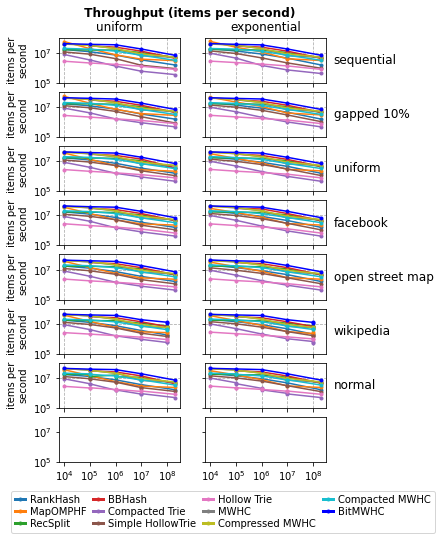

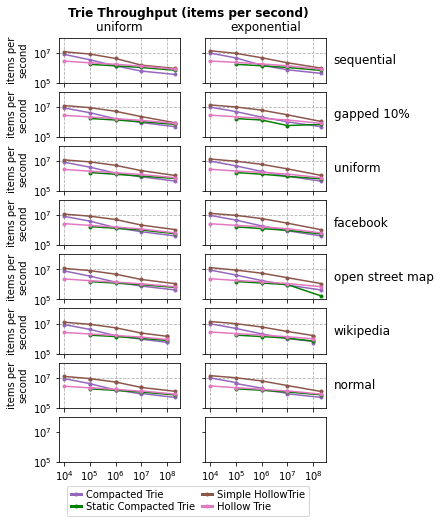

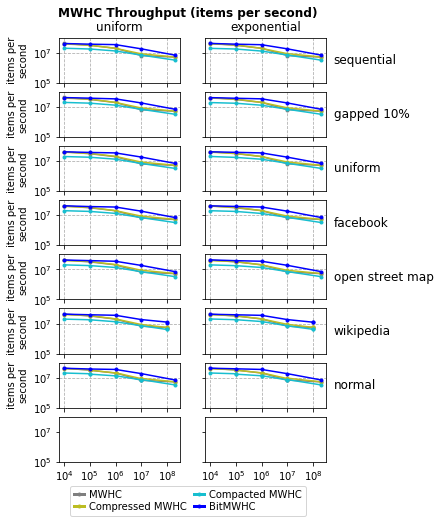

In [24]:
def plot_throughput_deterioration(data, log_scale_y, title_prefix, name_suffix, only_plot=None, ncols=2, xoff=0.5, yoff=0.02):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.65), sharex=True, sharey=True)

    data = data.sort_values(by=[order_key, dataset_size_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        axs[i][0].set_ylabel("items per\nsecond")
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]

            ax.set_xscale('log')
            if log_scale_y:
                ax.set_yscale('log')
            ax.set_ylim([10**5, 10**8])
            ax.set_xticks([10**i for i in [4, 5, 6, 7, 8, 9]])
#             if i == rows - 1:
#                 ax.set_xlabel("dataset size")
            ax.grid(linestyle="--", axis="both")
    
            for k, (name, df) in enumerate(df.groupby([func_key], sort=False)):
                if only_plot != None and name not in only_plot:
                    continue
                ax.plot(dataset_size_key, throughput_key, data=df, color=get_color(name), label=function_name(name), linewidth=1.5, marker='.')
                
            if i == 0:
                # ax.set_ylabel("normalized entries per slot")
                ax.annotate(probing_dist, 
                            xy=(0.5, 1), 
                            xytext=(0, pad), 
                            xycoords='axes fraction', 
                            textcoords='offset points', 
                            size='large', 
                            ha='center', 
                            va='baseline',
                           )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(xoff, yoff),
               ncol=ncols,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"{title_prefix} Throughput (items per second)", y=0.935, fontweight="bold")
    
    fig.savefig(f"throughput_deterioration_{name_suffix}.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput_deterioration_{name_suffix}.pgf", bbox_inches="tight", dpi=300)

reset_colors()
plot_throughput_deterioration(th_df, True, "", "all", [
    # 'BBHash1',
    'BBHash2',
    'BitMWHC',
    'CompactTrie',
    # 'CompactedCompactTrie',
    'CompactedMWHC',
    'CompressedMWHC',
    # 'CompressedRankHash',
    # 'DoNothingHash',
    'HollowTrie',
    'MWHC',
    'MapOMPHF',
    'RankHash',
    'RecSplit_leaf12_bucket9',
    'SimpleHollowTrie'
], ncols=4, xoff=0.6, yoff=-0.01)
plot_throughput_deterioration(th_df, True, "Trie", "trie", ["SimpleHollowTrie", "HollowTrie", "CompactTrie", "CompactedCompactTrie", "FastSuccinctTrie"])
plot_throughput_deterioration(th_df, True, "MWHC", "mwhc", ["MWHC", "CompressedMWHC", "CompactedMWHC", "BitMWHC"])

In [80]:
def plot_throughput(data):
    dists = set(data[probing_dist_key])
    
    rows = 8
    cols = len(dists)
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.65), sharex=True, sharey=True)

    data = data[data[dataset_size_key] > 10**7].copy(deep=True).sort_values(by=[order_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        axs[i][0].set_ylabel("items per\nsecond")
        for j, (probing_dist, df) in enumerate(df.groupby([probing_dist_key], sort=False)):            
            ax = axs[i][j]

            ax.set_ylim([4*10**5, 1.5 * 10**7])
            ax.set_yscale('log')
            ax.grid(linestyle="--", axis="both")
    
            for k, (name, df) in enumerate(df.groupby([func_key], sort=False)):
                if name == "DoNothingHash":
                    continue
                ax.bar(data=df, x=k, height=throughput_key, label=function_name(name, params=True), color=get_color(name))
                
            if i == 0:
                ax.annotate(
                    probing_dist, 
                    xy=(0.5, 1), 
                    xytext=(0, pad), 
                    xycoords='axes fraction', 
                    textcoords='offset points', 
                    size='large', 
                    ha='center', 
                    va='baseline',
                )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.5, 1),
               ncol=3,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"Throughput ($10^8$ elements)", y=0.935, fontweight="bold")
    
    fig.savefig(f"throughput.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"throughput.pgf", bbox_inches="tight", dpi=300)

plot_throughput(th_df)

RuntimeError: The command
    pdflatex -interaction=nonstopmode -halt-on-error figure.tex
failed and generated the following output:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./figure.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-02-24>
(/usr/local/texlive/2022/texmf-dist/tex/latex/hyperref/hyperref.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/ltxcmds/ltxcmds.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/iftex.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pdftexcmds/pdftexcmds.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/infwarerr/infwarerr.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/kvsetkeys/kvsetkeys.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/kvdefinekeys/kvdefinekeys.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pdfescape/pdfescape.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/hycolor/hycolor.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/letltxmacro/letltxmacro.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/auxhook/auxhook.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/kvoptions/kvoptions.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/hyperref/pd1enc.def)
(/usr/local/texlive/2022/texmf-dist/tex/generic/intcalc/intcalc.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/etexcmds/etexcmds.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/hyperref/puenc.def)
(/usr/local/texlive/2022/texmf-dist/tex/latex/url/url.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/bitset/bitset.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/bigintcalc/bigintcalc.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/atbegshi-ltx.sty)

Package hyperref Warning: Option `pdfpagelabels' is turned off
(hyperref)                because \thepage is undefined.

) (/usr/local/texlive/2022/texmf-dist/tex/latex/hyperref/hpdftex.def
(/usr/local/texlive/2022/texmf-dist/tex/latex/rerunfilecheck/rerunfilecheck.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/base/atveryend-ltx.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/uniquecounter/uniquecounter.sty
))) (/usr/local/texlive/2022/texmf-dist/tex/latex/base/minimal.cls
Document Class: minimal 2001/05/25 Standard LaTeX minimal class
) (/usr/local/texlive/2022/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/iftex/ifvtex.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.te
x
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-li
sts.tex))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def
) (/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfrcs.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/pgf.revision.tex)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/basiclayer/pgfcore.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/graphics.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics/trig.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/graphics.cfg)
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-def/pdftex.def)))
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/systemlayer/pgfsys.sty
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgfsys.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfkeys.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/utilities/pgfkeysfiltered.c
ode.tex))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgf.cfg)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-pdftex.d
ef
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgfsys-common-p
df.def)))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgfsyssoftpath.
code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/systemlayer/pgfsysprotocol.
code.tex)) (/usr/local/texlive/2022/texmf-dist/tex/latex/xcolor/xcolor.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/graphics-cfg/color.cfg))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcore.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmath.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathcalc.code.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathutil.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathparser.code.tex
)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.code.
tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.basic
.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.trigo
nometric.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.rando
m.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.compa
rison.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.base.
code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.round
.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.misc.
code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfunctions.integ
erarithmetics.code.tex)))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfmathfloat.code.tex)
) (/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/math/pgfint.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepoints.co
de.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathconst
ruct.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathusage
.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorescopes.co
de.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoregraphicst
ate.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretransform
ations.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorequick.cod
e.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreobjects.c
ode.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepathproce
ssing.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorearrows.co
de.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreshade.cod
e.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreimage.cod
e.tex
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoreexternal.
code.tex))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorelayers.co
de.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcoretranspare
ncy.code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorepatterns.
code.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/basiclayer/pgfcorerdf.code.
tex)))
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/modules/pgfmoduleshapes.cod
e.tex)
(/usr/local/texlive/2022/texmf-dist/tex/generic/pgf/modules/pgfmoduleplot.code.
tex)
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version
-0-65.sty)
(/usr/local/texlive/2022/texmf-dist/tex/latex/pgf/compatibility/pgfcomp-version
-1-18.sty))
(/usr/local/texlive/2022/texmf-dist/tex/latex/l3backend/l3backend-pdftex.def)
No file figure.aux.
(/usr/local/texlive/2022/texmf-dist/tex/latex/hyperref/nameref.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/refcount/refcount.sty)
(/usr/local/texlive/2022/texmf-dist/tex/generic/gettitlestring/gettitlestring.s
ty))
*geometry* driver: auto-detecting
*geometry* detected driver: pdftex
(/usr/local/texlive/2022/texmf-dist/tex/context/base/mkii/supp-pdf.mkii
[Loading MPS to PDF converter (version 2006.09.02).]
) (/usr/local/texlive/2022/texmf-dist/tex/latex/epstopdf-pkg/epstopdf-base.sty
(/usr/local/texlive/2022/texmf-dist/tex/latex/latexconfig/epstopdf-sys.cfg))
(./figure.pgf
! Dimension too large.
<to be read again> 
                   \relax 
l.75 ...eto{\pgfqpoint{0.807640in}{-226.705462in}}
                                                  %
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on figure.log.

and the following error:


<Figure size 345.6x561.6 with 16 Axes>

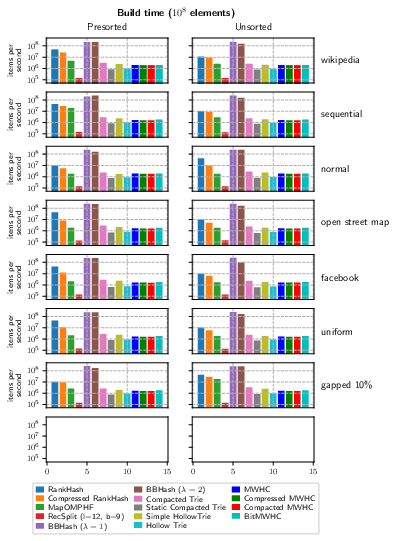

In [86]:
def plot_build_time(data):
    rows = 8
    cols = 2
    
    fig, axs = plt.subplots(rows, cols, figsize=(fig_width*0.8, rows*fig_height*0.65), sharex=True, sharey=True)

    data = data[data[dataset_size_key] >= 10**8].copy(deep=True).sort_values(by=[order_key])
    for i, (dataset, df) in enumerate(data.groupby([dataset_key], sort=False)):
        pad = 7.5
        axs[i][-1].annotate(
            dataset, 
            xy=(0, 0.5),
            xytext=(125 + axs[i][-1].yaxis.labelpad + pad, 0),
            xycoords=axs[i][-1].yaxis.label, 
            textcoords='offset points',
            size='large', 
            ha='left', 
            va='center',
            rotation=0
        )
        axs[i][0].set_ylabel("items per\nsecond")
        for j, (presorted, df) in enumerate(df.groupby([presorted_key], sort=False)):            
            ax = axs[i][j]

            ax.set_yscale('log')
            ax.set_yticks([10**i for i in [5, 6, 7, 8]])
            ax.set_ylim([5 * 10**4, 5 * 10**8])
            ax.grid(linestyle="--", axis="both")
    
            for k, (name, df) in enumerate(df.groupby([func_key], sort=False)):
                if name == "DoNothingHash":
                    continue
                ax.bar(data=df, x=k, height=throughput_key, label=function_name(name, params=True), color=get_color(name))
                
            if i == 0:
                ax.annotate(
                    "Presorted" if presorted else "Unsorted", 
                    xy=(0.5, 1), 
                    xytext=(0, pad), 
                    xycoords='axes fraction', 
                    textcoords='offset points', 
                    size='large', 
                    ha='center', 
                    va='baseline',
                )
                
            ax.tick_params(
                axis='x',
                which='both',
                top=False, 
                bottom=False, 
                labelbottom=False
            )

    h, l = axs[0][0].get_legend_handles_labels()
    legend = fig.legend(h, l, 
               loc='lower center',
               bbox_to_anchor=(0.5, -0.01),
               ncol=3,
               borderpad=0.4, 
               labelspacing=0.2, 
               handlelength=1.0, 
               handletextpad=0.5, 
               columnspacing=0.7
              )
    for line in legend.get_lines():
        line.set_linewidth(3.0)
                
    # overall title
    fig.suptitle(f"Build time ($10^8$ elements)", y=0.935, fontweight="bold")
    
    fig.savefig(f"build.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"build.pgf", bbox_inches="tight", dpi=300)

plot_build_time(bt_df)